# 赛题背景分析与理解

本次学术论文趋势分析，数据预处理部分主要方法，已经由Baseline提供了，所以数据基本上不需要太多的额外处理，需要的只是在不同的维度去解析论文数量的变化趋势，发现潜在的趋势规律  
当然我做的很浅显，没有用什么高级的预测模型进行预测，但是探索了Python、Excel、Tableau三种方式分别来完成相同的可视化任务，数据分析的基本流程就是：
1. SQL取数据  
2. Python对数据进行清洗  
3. Tableau(大数据）、Excel(小数据）绘制各种透视图和指标仪表   
4. 使用Python运用各种机器学习、深度学习方法进行建模，完成分析预测等  

# 赛题方案-可视化 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import json

from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息

## 数据读取

### 读取原始数据
- 数据集来源：[数据集链接](https://www.kaggle.com/Cornell-University/arxiv)；
- 数据集的格式如下：
  - `id`：arXiv ID，可用于访问论文；
  - `submitter`：论文提交者；
  - `authors`：论文作者；
  - `title`：论文标题；
  - `comments`：论文页数和图表等其他信息；
  - `journal-ref`：论文发表的期刊的信息；
  - `doi`：数字对象标识符，[https://www.doi.org](https://www.doi.org)；
  - `report-no`：报告编号；
  - `categories`：论文在 arXiv 系统的所属类别或标签；
  - `license`：文章的许可证；
  - `abstract`：论文摘要；
  - `versions`：论文版本；
  - `authors_parsed`：作者的信息。

In [4]:
# 读取json数据
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi','report-no', 'categories', 'license', 'abstract', 'versions','update_date', 'authors_parsed'], count=None):
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data


data = readArxivFile('D:\code\Github\data\AcademicTrendsAnalysis/arxiv-metadata-oai-snapshot.json', ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'categories', 'abstract', 'versions','update_date', 'authors_parsed'])

### 抽取5%的数据作为样本进行分析
- 注释掉此段代码，就可以对全部数据进行分析，限于本人的机子性能有限，所以只取5%的数据进行分析

In [5]:
data = data.sample(frac =0.05,replace = False,random_state = 1 )
# 清理内存垃圾
import gc
gc.collect()

76

In [6]:
# 存储转换后的数据
data.to_csv('D:\code\Github\data\AcademicTrendsAnalysis\data.csv',index = False)

In [3]:
data.head(3)

,id,submitter,authors,title,comments,journal-ref,categories,abstract,versions,update_date,authors_parsed
0,1506.04017,Serena Ng,Jean-Jacques Forneron and Serena Ng,A Likelihood-Free Reverse Sampler of the Poste...,NaN,NaN,stat.ME,This paper considers properties of an optimi...,"[{'version': 'v1', 'created': 'Fri, 12 Jun 201...",2015-12-02,"[['Forneron', 'Jean-Jacques', ''], ['Ng', 'Ser..."
1,gr-qc/9211024,NaN,R. Mansouri and M.Mohazzab (BROWN),Tunneling in Anisotropic Cosmological Models,"13 pages, phyzzx","Class.Quant.Grav.10:1353-1359,1993",gr-qc,Tunneling rate is investigated in homogenous...,"[{'version': 'v1', 'created': 'Thu, 19 Nov 199...",2010-04-06,"[['Mansouri', 'R.', '', 'BROWN'], ['Mohazzab',..."
2,2011.02152,Rotem Liss,"Rotem Liss, Tal Mor","From Practice to Theory: The ""Bright Illuminat...",17 pages,NaN,quant-ph cs.CR,"The ""Bright Illumination"" attack [Lydersen e...","[{'version': 'v1', 'created': 'Wed, 4 Nov 2020...",2020-11-05,"[['Liss', 'Rotem', ''], ['Mor', 'Tal', '']]"


### 爬取论文类别信息
- group_name 论文大类
- archive_name 论文子类（除了物理学领域，其他种类都没有子类） 
- archive_id 论文子类的缩写
- category_name 论文细类的名称
- categories 论文细类的缩写

In [4]:
#爬取所有的类别
website_url = requests.get('https://arxiv.org/category_taxonomy').text #获取网页的文本数据
soup = BeautifulSoup(website_url,'lxml') #爬取数据，这里使用lxml的解析器，加速
root = soup.find('div',{'id':'category_taxonomy_list'}) #找出 BeautifulSoup 对应的标签入口
tags = root.find_all(["h2","h3","h4","p"], recursive=True) #读取 tags

#初始化 str 和 list 变量
level_1_name = ""
level_2_name = ""
level_2_code = ""
level_1_names = []
level_2_codes = []
level_2_names = []
level_3_codes = []
level_3_names = []
level_3_notes = []

#进行
for t in tags:
    if t.name == "h2":
        level_1_name = t.text    
        level_2_code = t.text
        level_2_name = t.text
    elif t.name == "h3":
        raw = t.text
        level_2_code = re.sub(r"(.*)\((.*)\)",r"\2",raw) #正则表达式：模式字符串：(.*)\((.*)\)；被替换字符串"\2"；被处理字符串：raw
        level_2_name = re.sub(r"(.*)\((.*)\)",r"\1",raw)
    elif t.name == "h4":
        raw = t.text
        level_3_code = re.sub(r"(.*) \((.*)\)",r"\1",raw)
        level_3_name = re.sub(r"(.*) \((.*)\)",r"\2",raw)
    elif t.name == "p":
        notes = t.text
        level_1_names.append(level_1_name)
        level_2_names.append(level_2_name)
        level_2_codes.append(level_2_code)
        level_3_names.append(level_3_name)
        level_3_codes.append(level_3_code)
        level_3_notes.append(notes)

#根据以上信息生成dataframe格式的数据
df_taxonomy = pd.DataFrame({
    'group_name' : level_1_names,
    'archive_name' : level_2_names,
    'archive_id' : level_2_codes,
    'category_name' : level_3_names,
    'categories' : level_3_codes,
    'category_description': level_3_notes
    
})
df_taxonomy.head()

In [ ]:
# 存储论文类别信息
df_taxonomy.to_csv('D:\code\Github\data\AcademicTrendsAnalysis\categories.csv',index = False)

In [2]:
data = pd.read_csv('D:\code\Github\data\AcademicTrendsAnalysis\data.csv')
df_taxonomy = pd.read_csv('D:\code\Github\data\AcademicTrendsAnalysis\categories.csv')

In [3]:
df_taxonomy.head(3)

,group_name,archive_name,archive_id,category_name,categories,category_description
0,Computer Science,Computer Science,Computer Science,Artificial Intelligence,cs.AI,"Covers all areas of AI except Vision, Robotics..."
1,Computer Science,Computer Science,Computer Science,Hardware Architecture,cs.AR,Covers systems organization and hardware archi...
2,Computer Science,Computer Science,Computer Science,Computational Complexity,cs.CC,"Covers models of computation, complexity class..."


### 处理多种类论文
- 有的论文同时属于多个种类，在统计时，只按照其最重要的类别（第一个类别）

In [5]:
data.categories.iloc[:5]

0                            stat.ME
1                              gr-qc
2                     quant-ph cs.CR
3                  cond-mat.mtrl-sci
4    math.FA math.AP math.CA math.DG
Name: categories, dtype: object

看到类别数据以空格分割

In [3]:
data['category'] = data.categories.str.split(' ',expand=True)[0]
print(data['category'].nunique())

172


### 表连接

In [4]:
data = data.merge(df_taxonomy,how='left',left_on='category',right_on='categories')

In [9]:
data.shape

(89846, 18)

### 提取论文的发表年份和月份

In [4]:
data['month'] = pd.to_datetime(data.update_date).dt.month
data['year'] = pd.to_datetime(data.update_date).dt.year

### 提取论文的页数，图数

In [5]:
# 将评论转换成pd.string类型
data.comments = data.comments.astype('string')
pat = '(\d+) pages'
data['pages'] = data.comments.str.extract(pat=pat)

pat = '(\d+) figures'
data['figure'] = data.comments.str.extract(pat)

In [ ]:
# 将文本转换为数字
data.pages = data.pages.fillna('0').astype(int)
# 避免0值参与计算的影响，将0值转换为空值，聚合计算时会自动忽略
data.loc[data.pages == 0] = np.nan

# 将文本转换为数字
data.figure = data.figure.fillna('0').astype(int)
# 避免0值参与计算的影响，将0值转换为空值，聚合计算时会自动忽略
data.figure.loc[data.figure == 0] = np.nan

### 提取论文的作者数量

- 将文本型的列表转换为python列表

In [6]:
import ast 
data.authors_parsed =  data.authors_parsed.apply(ast.literal_eval)

- 统计作者数量

In [7]:
data['author_num'] = data.authors_parsed.apply(len)

### 删除重复的论文
- 一篇论文可能多次提交，因此有多个版本，只保留第一个版本

In [8]:
data = data.drop_duplicates(['id','category'],keep = 'first')

In [12]:
data.to_csv('D:\code\Github\data\AcademicTrendsAnalysis\data_processed.csv',index=False)

## 论文趋势分析-python

### 论文大类总体分析

#### 各大类论文总数
- 物理，数学，计算机科学是数量最多的三大门类
- 统计学，计量生物学等门类的数量较少

In [15]:
group1 = data.groupby('group_name')['id'].agg('count').sort_values(ascending = False).to_frame()
group1 = group1.reset_index()
group1.columns = ['group_name','count']

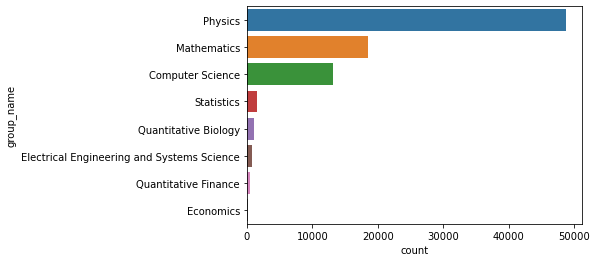

In [18]:
sns.barplot(x = 'count',y = 'group_name',data = group1)

#### 各类论文数量随年份的变化
- 可以看到计算机科学的论文数量随着时间，增长越来越快，数学次之
- 物理学领域的论文数量变化较大，但总体也呈现上升趋势
- 其他领域的论文数量则增幅很小

In [26]:
group2 = data.groupby(['group_name','year'])['id'].agg('count').to_frame()
group2 = group2.reset_index()
group2.columns = ['group_name','year','count']

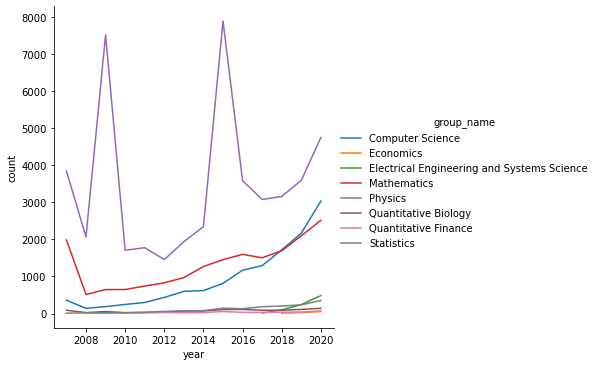

In [30]:
sns.relplot(data=group2,x='year',y = 'count',hue='group_name',kind='line')

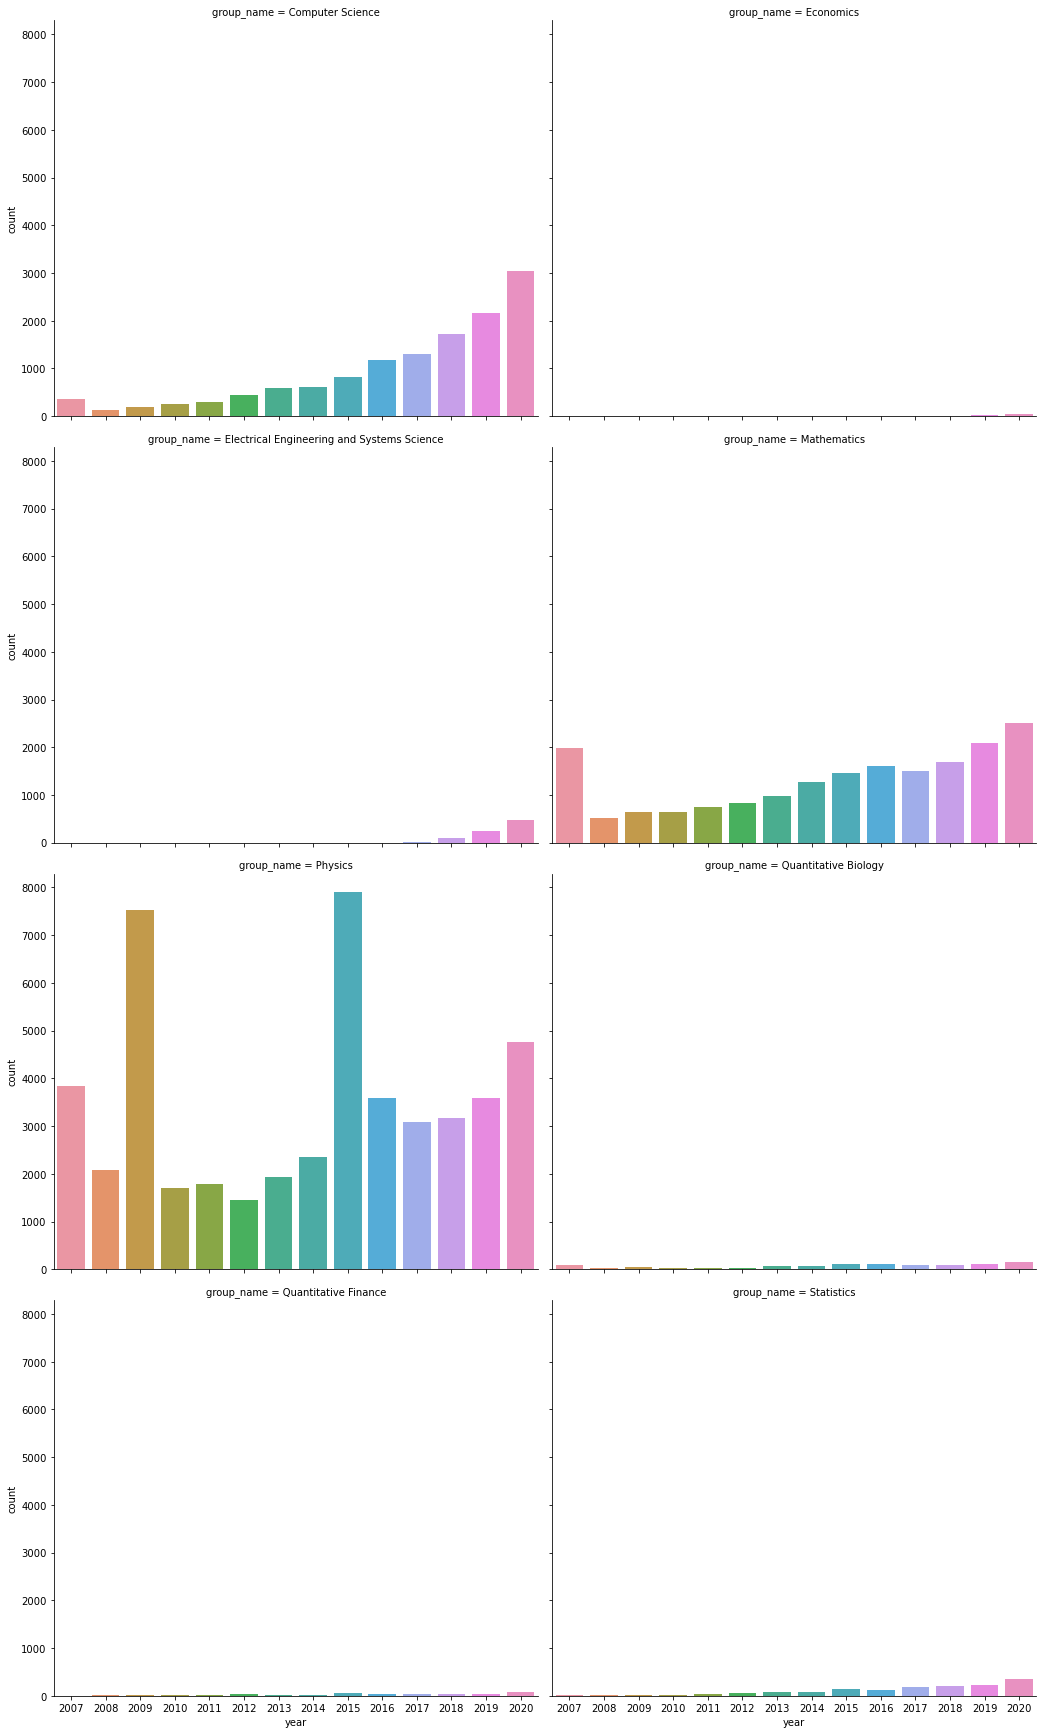

In [36]:
sns.catplot(data = group2,x = 'year',y ='count',col='group_name'
            ,col_wrap=2,height=6,aspect=1.2,kind='bar')

#### 论文总数量随时间的变化

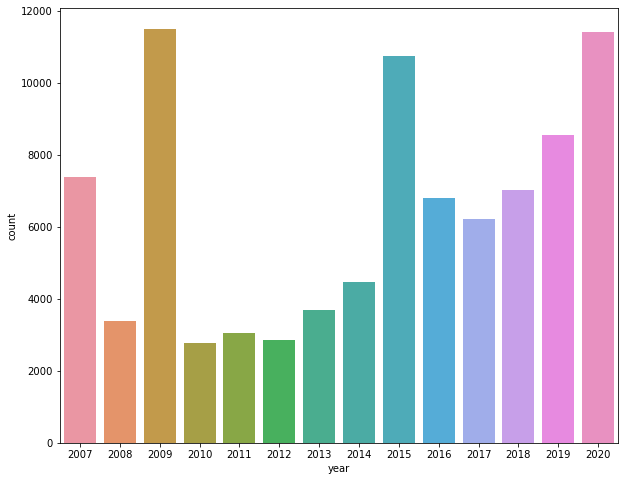

In [43]:
group3 = data.groupby('year')['id'].agg('count').sort_values(ascending = False).to_frame().reset_index()
group3.columns = ['year','count']
plt.figure(figsize = (10,8))
sns.barplot(data=group3,x='year',y='count')

#### 不同大类论文页数的不同
- 可以看到计算机科学的平均论文页数并不算高
- 经济学，数学，统计学的论文页数较多

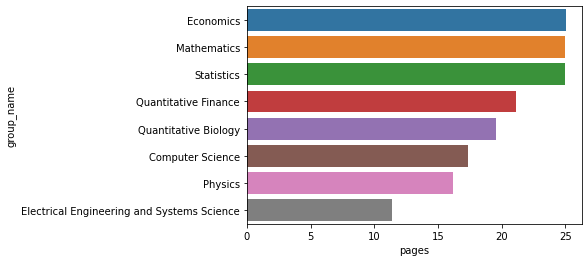

In [50]:
group4 = data.groupby('group_name')['pages'].agg('mean').sort_values(ascending = False).to_frame().reset_index()
group4.columns = ['group_name','pages']
sns.barplot(data=group4,x='pages',y='group_name')

#### 不同大类合作作者数量的不同
- 物理学领域论文平均每篇的作者数量最多，为5人
- 数学领域论文平均每篇的作者数量最少，只有不到2人

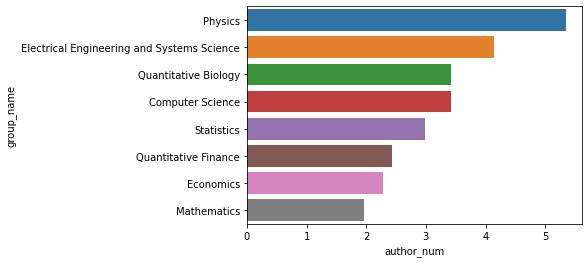

In [52]:
group4 = data.groupby('group_name')['author_num'].agg('mean').sort_values(ascending = False).to_frame().reset_index()
group4.columns = ['group_name','author_num']
sns.barplot(data=group4,x='author_num',y='group_name')

### 计算机领域论文趋势分析

#### 各领域论文的总数量
- 计算机视觉，机器学习果然是计算机科学论文最多的领域

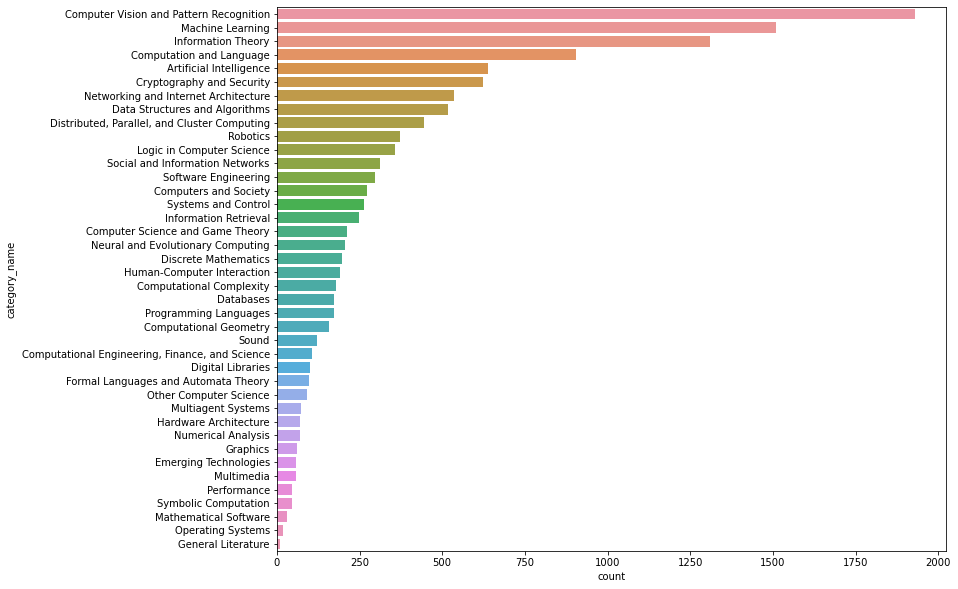

In [56]:
group5 = data.loc[data.group_name == 'Computer Science'].groupby('category_name')['id'].agg('count').sort_values(ascending = False).to_frame().reset_index()
group5.columns = ['category_name','count']
plt.figure(figsize=(12,10))
sns.barplot(data=group5,x='count',y='category_name')

#### 各领域论文数量随时间的变换
- 可以看到除了机器学习，机器视觉，自然语言处理增长较快之外，其他领域的论文数量增长都比较慢
- 信息理论，密码学与安全，机器人是除了ML，CV，NLP之外发表论文数量比较多的领域
- ML和CV还是计算机科学领域最火的方向

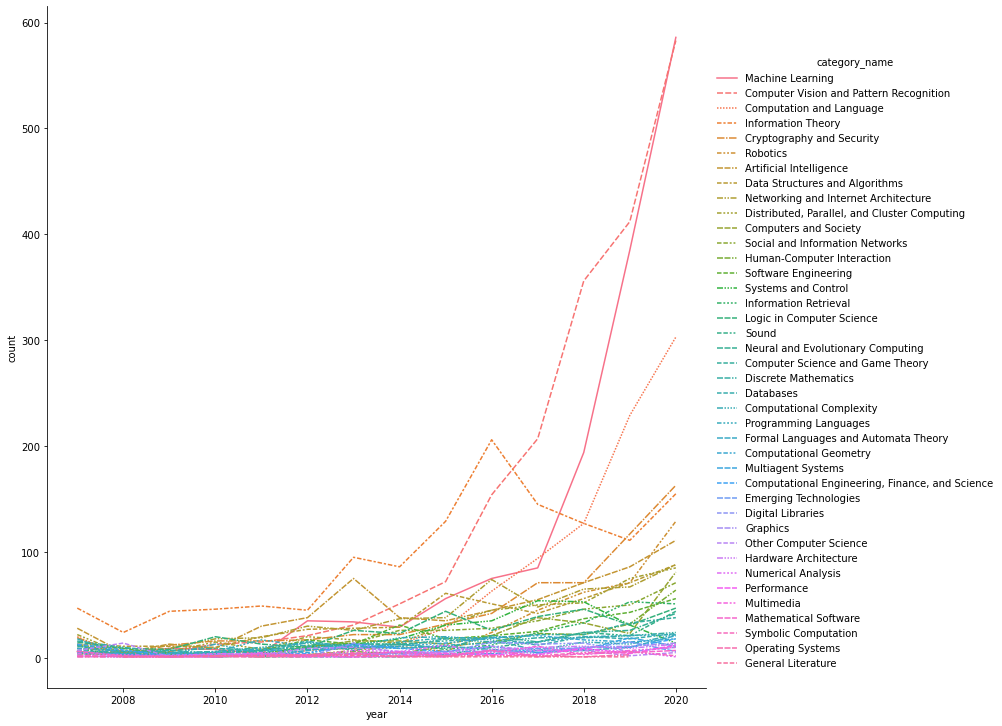

In [63]:
group6 = data.loc[data.group_name == 'Computer Science'].groupby(['category_name','year'])['id'].agg('count').sort_values(ascending = False).to_frame().reset_index()
group6.columns = ['category_name','year','count']
sns.relplot(data=group6,x='year',y = 'count',hue='category_name',kind='line',height = 10,style = 'category_name',palette='husl')

- Y轴相同刻度，查看相对数量

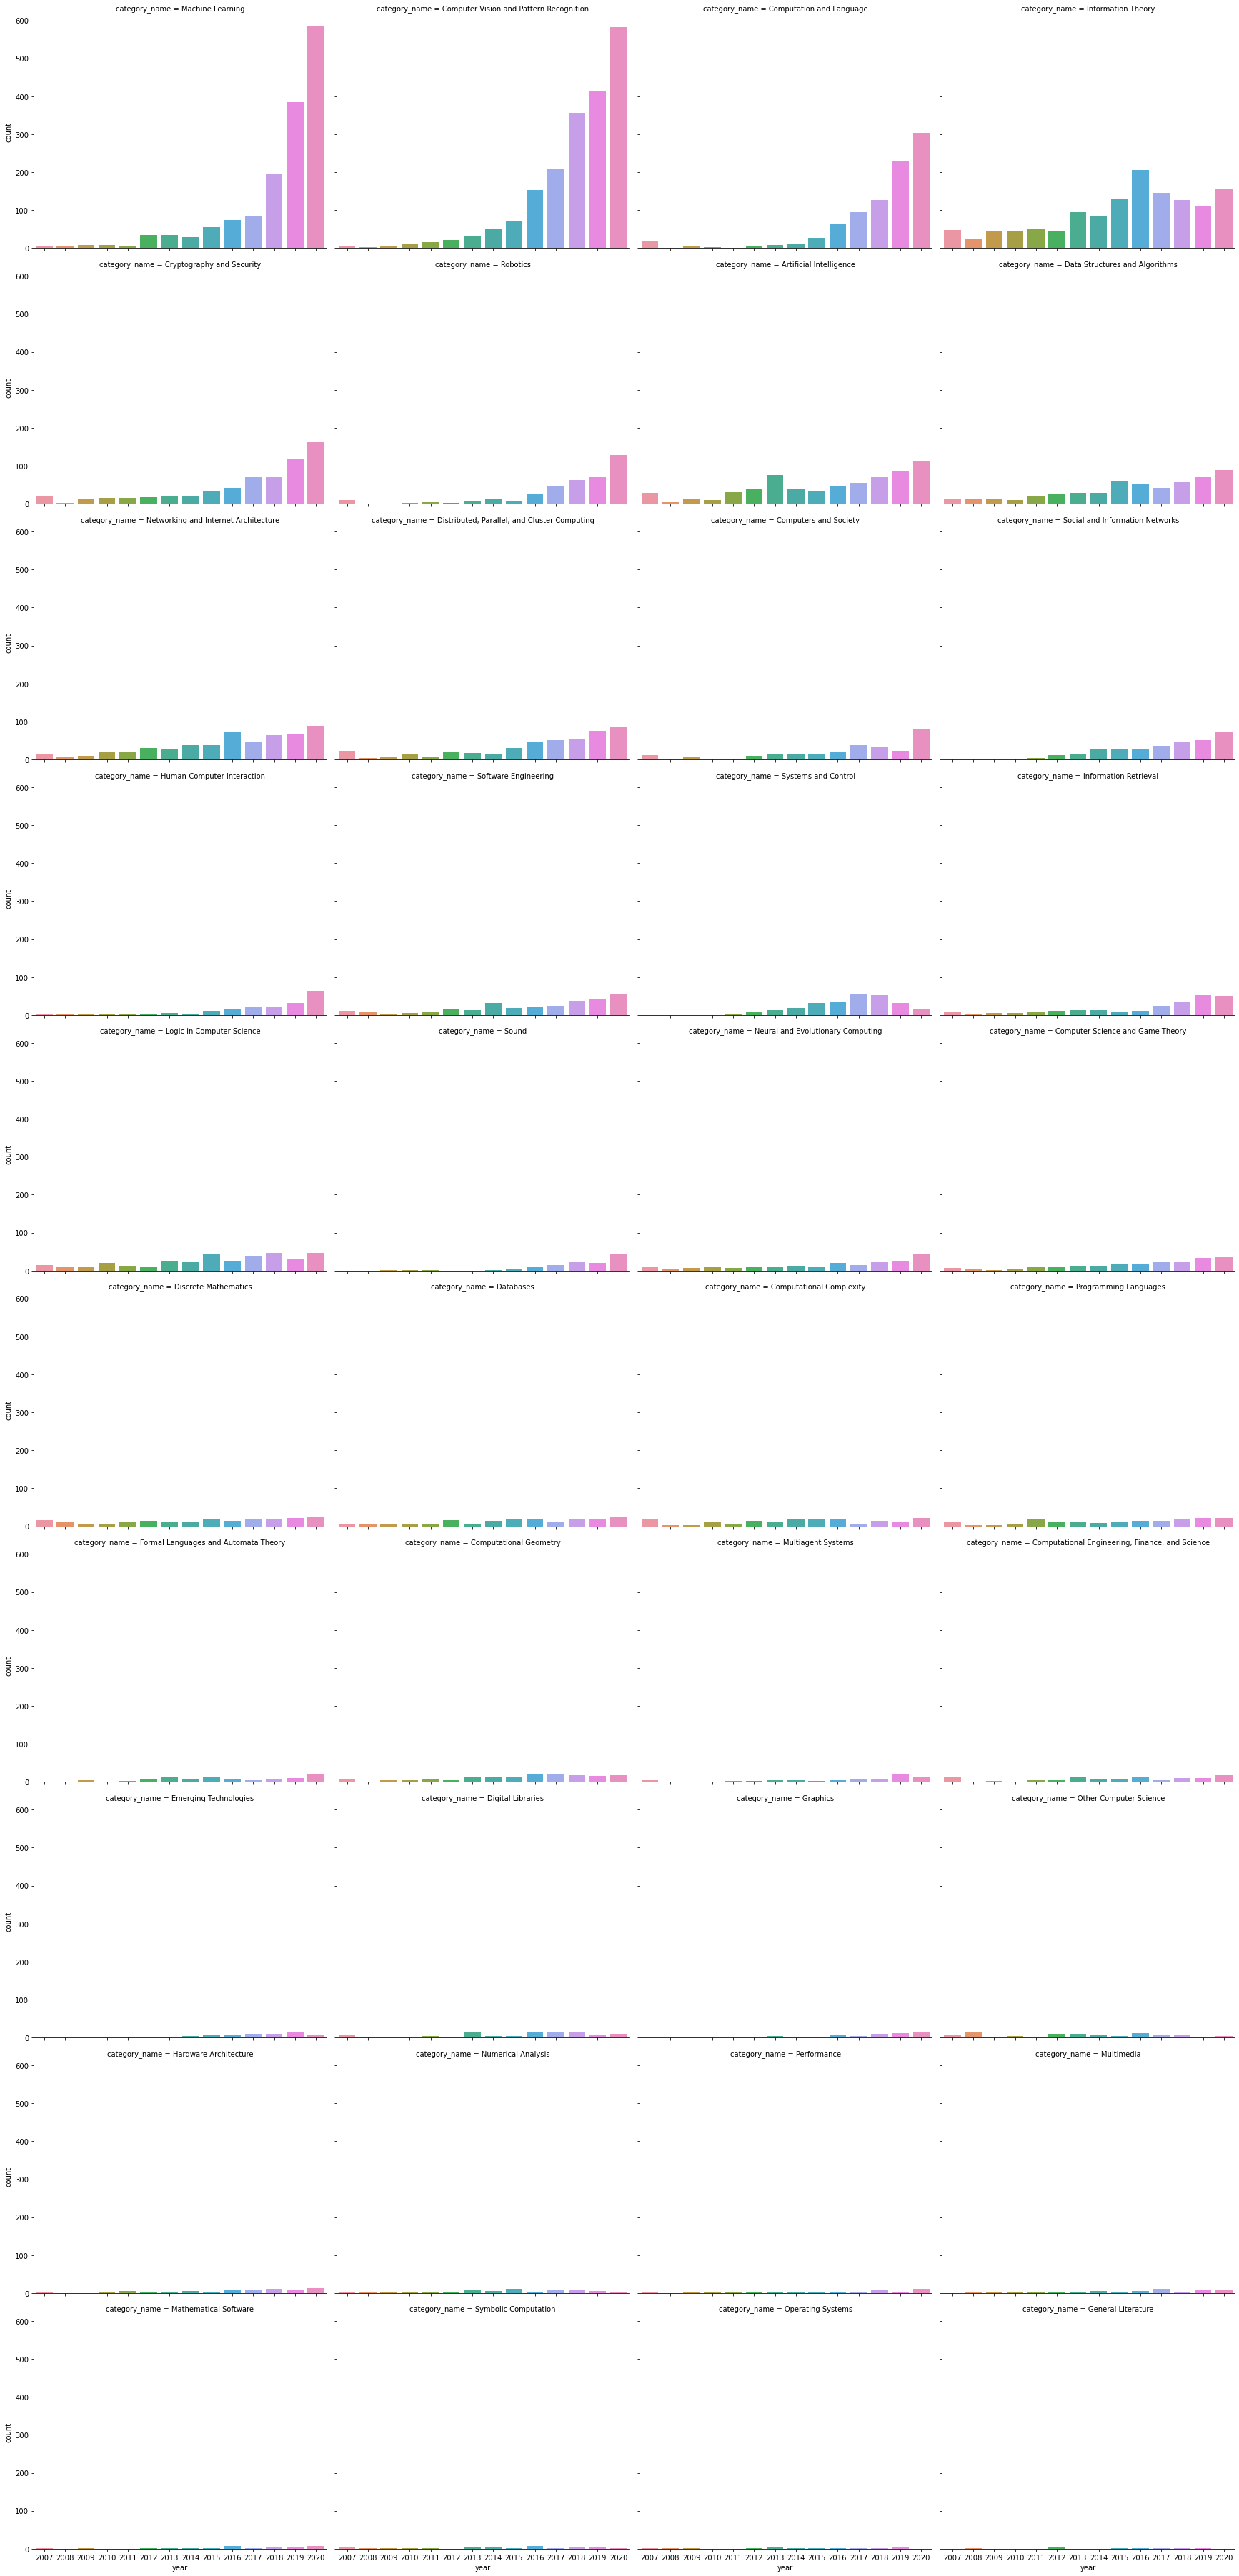

In [64]:
sns.catplot(data = group6,x = 'year',y ='count',col='category_name'
            ,col_wrap=4,height=5,aspect=1.2,kind='bar')

- Y轴不同刻度，查看变化趋势

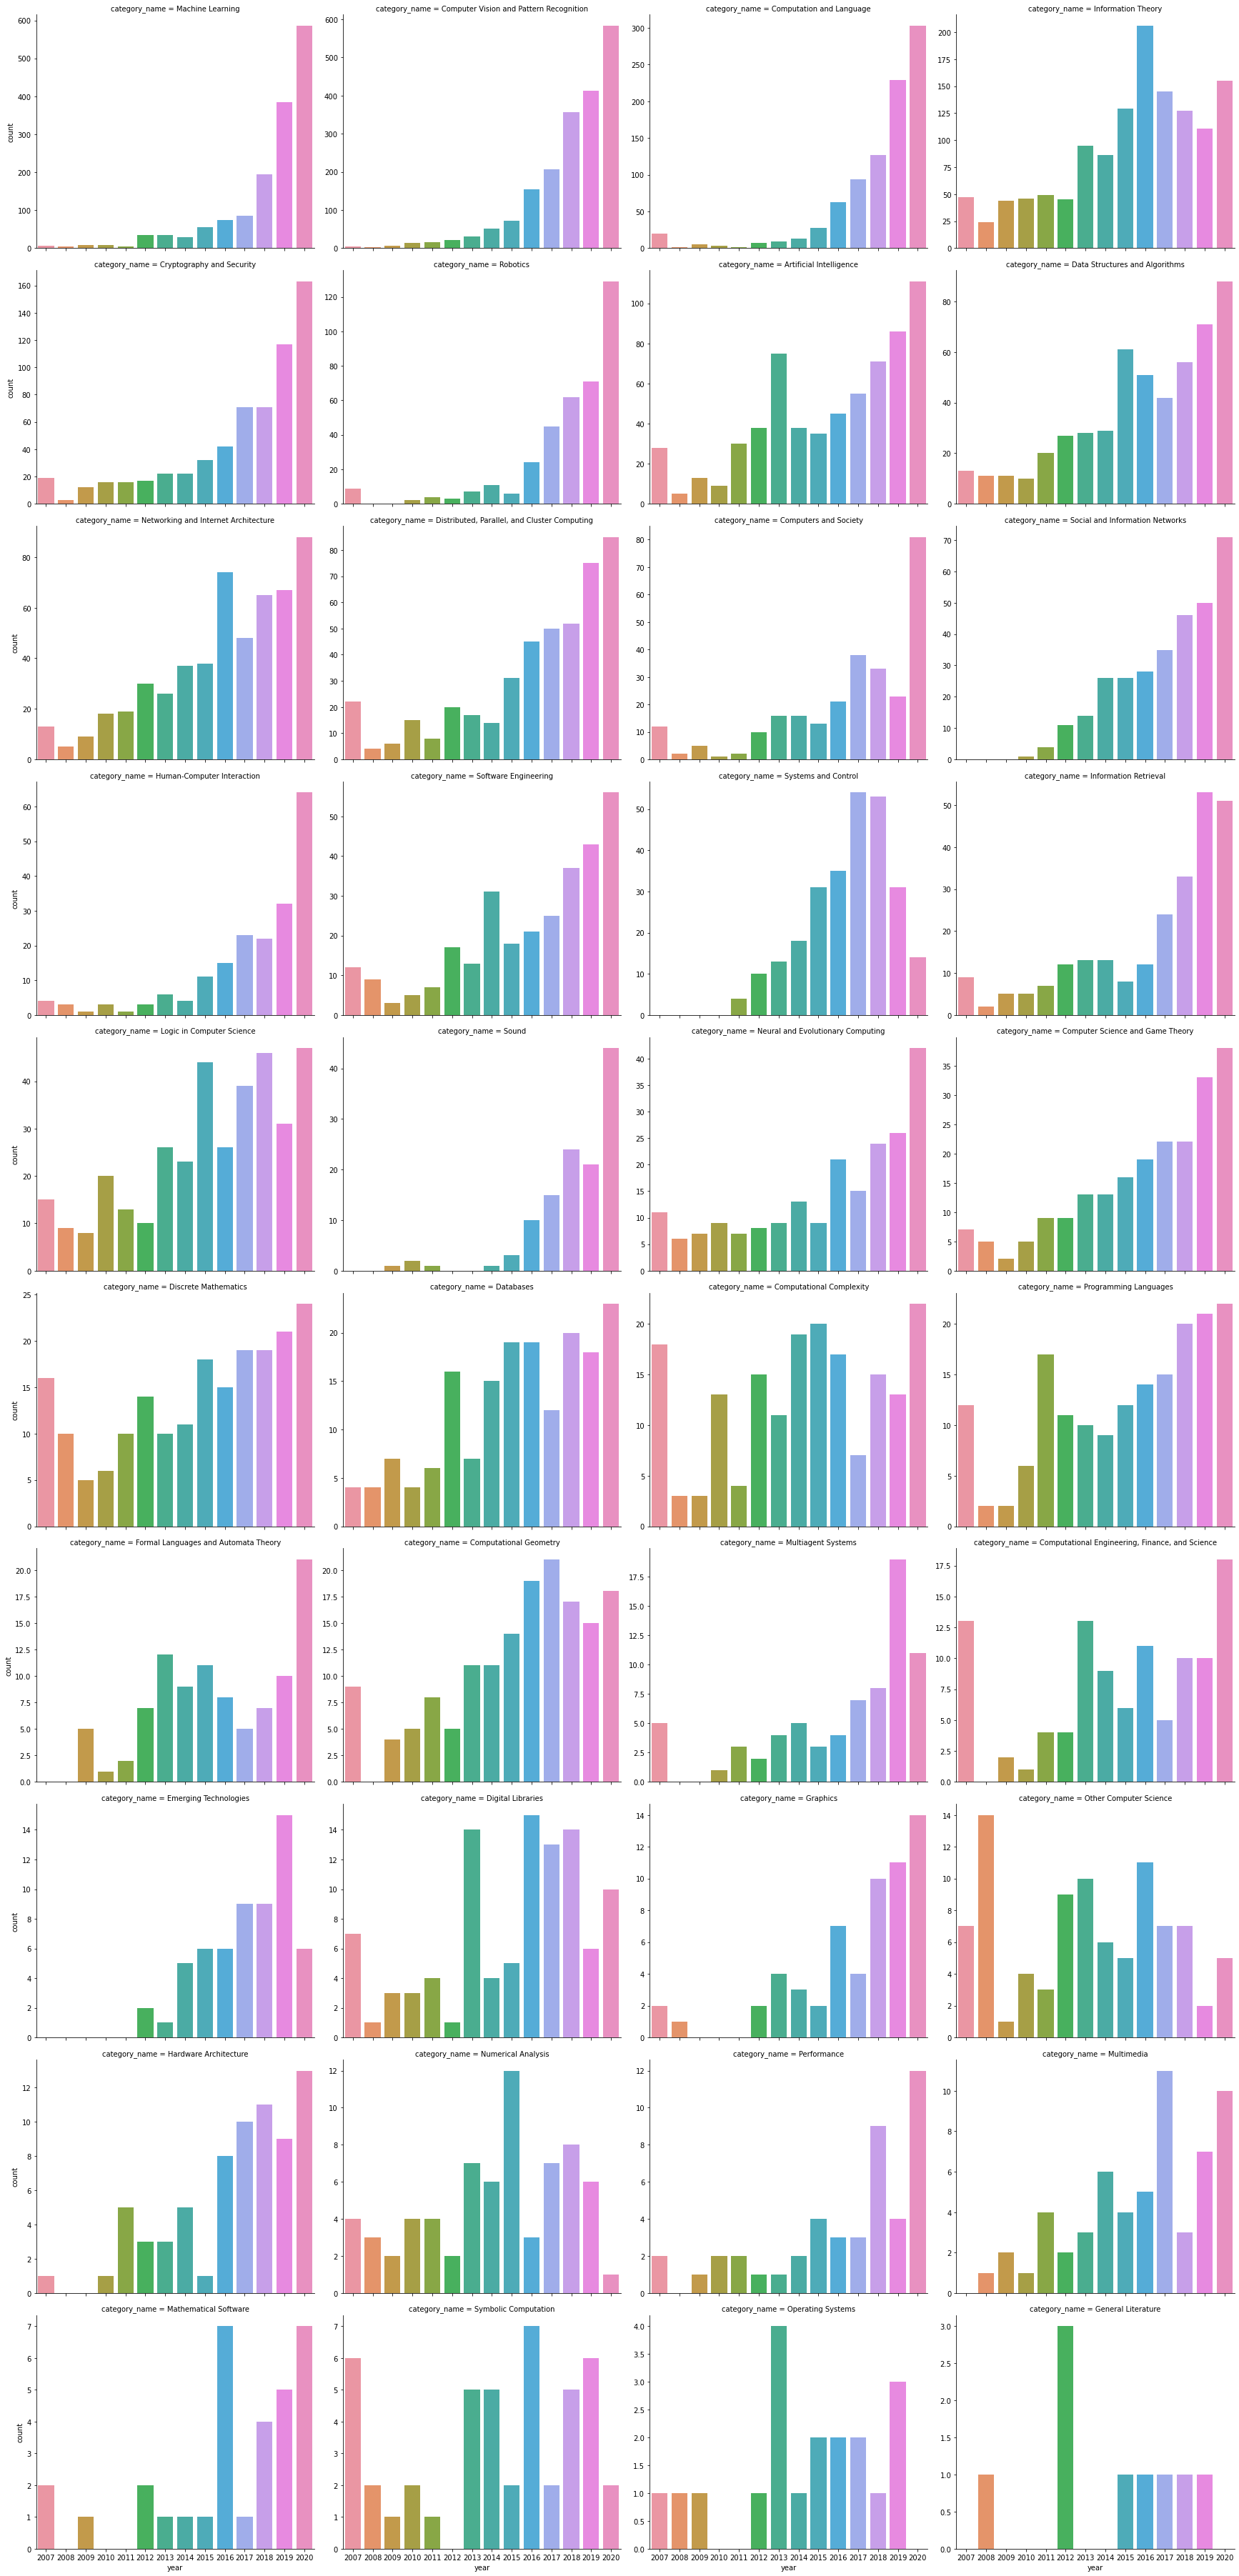

In [65]:
sns.catplot(data = group6,x = 'year',y ='count',col='category_name'
            ,col_wrap=4,height=5,aspect=1.2,kind='bar',sharey=False)

#### 论文页数
- 人工智能，编程语言，数值分析领域的论文页数最长
- CV和NLP的平均页数未进入前20

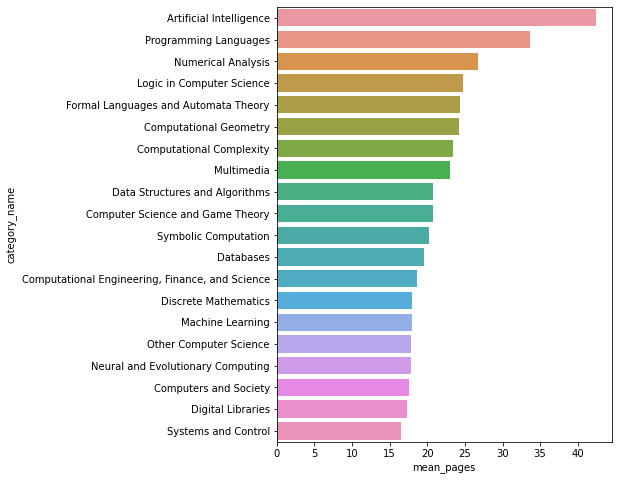

In [71]:
group7 = data.loc[data.group_name == 'Computer Science'].groupby('category_name')['pages'].agg('mean').sort_values(ascending = False).to_frame().reset_index().head(20)
group7.columns = ['category_name','mean_pages']
plt.figure(figsize=(6,8))
sns.barplot(data=group7,x='mean_pages',y='category_name')

#### 计算机视觉领域的合作作者数量最多

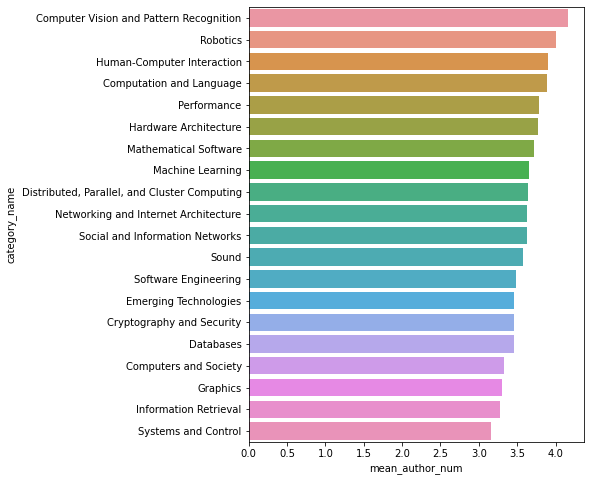

In [73]:

group8 = data.loc[data.group_name == 'Computer Science'].groupby('category_name')['author_num'].agg('mean').sort_values(ascending = False).to_frame().reset_index().head(20)
group8.columns = ['category_name','mean_author_num']
plt.figure(figsize=(6,8))
sns.barplot(data=group8,x='mean_author_num',y='category_name')

## 使用Excel分析

若图片无法显示，请点击：[链接](https://blog.csdn.net/weixin_43822124/article/details/113446511) 查看

### 创建数据透视表

1. 将存储的csv文件另存为excel文件，并随便创建打开一个excel文件
2. 点击数据选项卡-获取外部数据-现有连接
   <div align = 'center'>
	<img src="https://img-blog.csdnimg.cn/2021013021262939.jpg" width = 50% alt="图片名称" align=center />
	</div>
3. 点击浏览，选择上面保存的`data_processed.xlsx`文件
  	<div align = 'center'>
	<img src="https://img-blog.csdnimg.cn/2021013021270536.jpg" width = 50% alt="图片名称" align=center />
	</div>
4. 更改属性，输入sql语句：  
```
	select * from [D:\code\Github\data\AcademicTrendsAnalysis\data_processed.xlsx].[data_processed$]A left join [D:\code\Github\data\AcademicTrendsAnalysis\categories.xlsx].[categories$]B on A.category = B.categories
```
<div align = 'center'>
<img src="https://img-blog.csdnimg.cn/20210130212739928.jpg" width = 50% alt="图片名称" align=center />
</div>
5.  点击确定，创建数据透视表


### 不同大类的论文数量随时间的变化趋势

1. 在数据透视表中选择
<div align = 'center'>
<img src="https://img-blog.csdnimg.cn/20210130212914855.jpg" width = 30% alt="图片名称" align=center />
</div>
2. 插入切片器，和折线图（前10）
计算机领域的论文变化趋势
<div align = 'center'>
<img src="https://img-blog.csdnimg.cn/2021013021300784.jpg" width = 100% alt="图片名称" align=center />
</div>
更改切片器选择，物理学领域的论文趋势变化（前10）
<div align = 'center'>
<img src="https://img-blog.csdnimg.cn/20210130213037706.jpg" width = 100% alt="图片名称" align=center />
</div>
3. 更改透视表设计，可以实现python的全部分析结果
<div align = 'center'>
<img src="https://img-blog.csdnimg.cn/2021013021310368.jpg" width = 100% alt="图片名称" align=center />
</div>


## 使用tableau进行分析

若图片无法显示，请点击：[链接](https://blog.csdn.net/weixin_43822124/article/details/113446511) 查看

### 计算机领域论文数量差异

<div align = 'center'>
<img src="https://img-blog.csdnimg.cn/20210130213144456.jpg" width = 100% alt="图片名称" align=center />
</div>

### 计算机领域论文数量变化（top5)


<div align = 'center'>
<img src="https://img-blog.csdnimg.cn/20210130213210937.jpg" width = 100% alt="图片名称" align=center />
</div>

### 计算机领域论文页数差异


<div align = 'center'>
<img src="https://img-blog.csdnimg.cn/20210130213249307.jpg" width = 100% alt="图片名称" align=center />
</div>


# 总结


总的来说，python，excel，tableau都能完成上述分析可视化任务，但是各有优缺点：
- python：
	- 适合做不规则数据的处理
	- 适合进行各种算法建模
	- 适合进行预测分析
- excel：
	- 适合小量规则数据的分析与可视化
	- 数据格式较为局限，数据量不易过大
- tableau
	- 适合大量数据的分析与可视化
	- 操作简单，比python敲代码作图更快捷

# 不足

1. 在baseline基础上，主要是探索了数据可视化的一些方法，未能对论文未来的变化数量进行预测，没有使用一些高级的分析预测模型，大家可以进行尝试  
2. 最近学习了时间序列的处理，论文的数量变化趋势就是一个时间序列，可以探索使用时间序列分析方法进行预测，比如传统的ARMA、ARIMA等，还有深度学习方法LSTM等方法